In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import muon
import ott
import functools
import logging
import typing as t

import anndata as ad
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import scanpy as sc
import scipy.sparse as sp
import scipy.stats as ss
from ott.geometry import costs, geometry, pointcloud
from ott.problems.linear import linear_problem, potentials
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from sklearn import metrics, model_selection
from ott.geometry import costs as sparse_costs

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)

import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['default', 'despine']


In [3]:
mudata = muon.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/mudata_with_annotation_all.h5mu")

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [5]:
mudata = mudata[mudata.obs["cell_type"].isin(endocrine_celltypes)]

In [6]:
def adapt_time(x):
    if x["stage"]=="E14.5":
        return 14.5
    if x["stage"]=="E15.5":
        return 15.5
    if x["stage"]=="E16.5":
        return 16.5
    raise ValueError

mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")

/tmp/ipykernel_284558/2312537565.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mudata.obs['time'] = mudata.obs.apply(adapt_time, axis=1).astype("category")


In [7]:
adata=mudata["rna"]


In [8]:
adata.obs["cell_type_refined"] = mudata.obs["cell_type_refined"]
adata.obsm["X_umap"] = mudata.obsm["X_umap"]
adata.obs["time"] = mudata.obs["time"] 

In [9]:
adata.X = adata.layers["raw_counts"]

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(adata, inplace=True, subset=True, n_top_genes=2000)

/home/icb/dominik.klein/mambaforge/envs/moscot_rev_new/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [12]:
gex_early = adata[adata.obs["time"]==15.5].X.A
gex_late = adata[adata.obs["time"]==16.5].X.A

In [13]:
x=gex_early
y=gex_late

In [14]:
solver = jax.jit(sinkhorn.Sinkhorn())


def entropic_map(x, y, cost_fn: costs.TICost) -> jnp.ndarray:
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, batch_size=1)
    output = solver(linear_problem.LinearProblem(geom))
    dual_potentials = output.to_dual_potentials()
    return dual_potentials.transport

In [15]:
map_l1 = entropic_map(x, y, costs.ElasticL1(scaling_reg=10.0))

In [16]:
from tqdm import tqdm
batch_size=100
push_forward = []
for i in tqdm(range(0, len(x), batch_size)):
    push_forward.append(map_l1(x[i:i+batch_size]))

100%|█████████████████████████████████████████████████████████████████████████████████████| 52/52 [1:07:49<00:00, 78.27s/it]


In [17]:
ls_flattened=[]
for el in push_forward:
    ls_flattened.extend(el)

In [18]:
res=np.asarray(ls_flattened)

In [19]:
gene_mask = (np.abs(res-x) > 1e-6)

In [20]:
adata_15 = adata[adata.obs["time"].isin((15.5, ))]

In [21]:
adata_15.layers["sparse_mask"] = gene_mask

/tmp/ipykernel_284558/1174042063.py:1: ImplicitModificationWarning: Setting element `.layers['sparse_mask']` of view, initializing view as actual.
  adata_15.layers["sparse_mask"] = gene_mask


In [23]:
import os
output_dir = "/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/sparse_monge"
adata_15.write(os.path.join(output_dir, "adata_15_with_sparse_mask_balanced.h5ad"))

In [24]:
adata_15.var["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=0)
adata_15.obs["sparse_counts"] = adata_15.layers["sparse_mask"].sum(axis=1)

In [25]:
adata_15.var["sparse_counts"].sort_values()[-5:]/len(adata_15)

Pyy      0.447158
Ctrb1    0.539754
Iapp     0.567298
Ins1     0.723970
Ins2     0.729244
Name: sparse_counts, dtype: float64

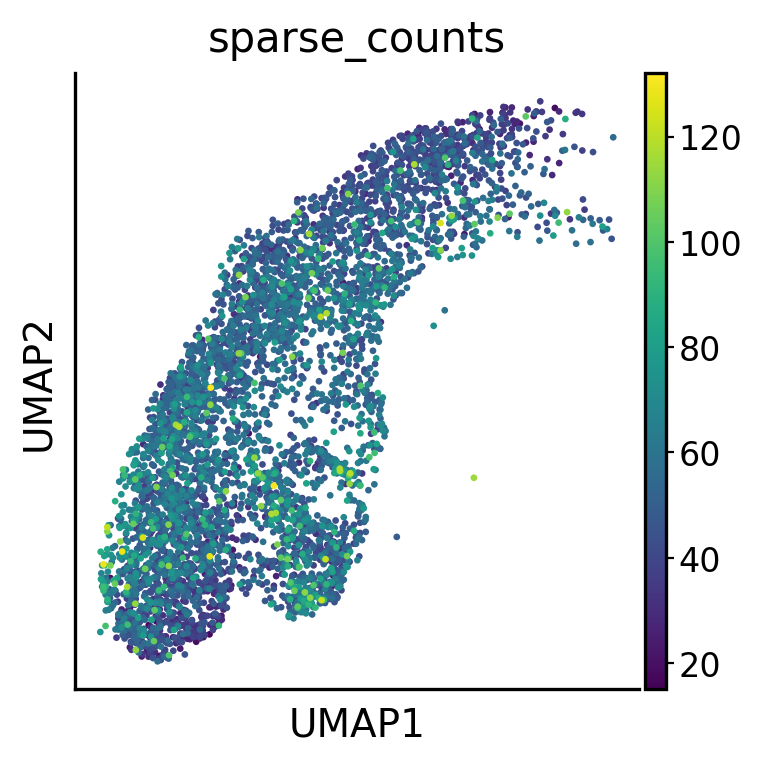

In [26]:
sc.pl.umap(adata_15, color='sparse_counts')

In [27]:
res_dict = {}
res_dict_2 = {}
for cell_type in endocrine_celltypes:
    adata_tmp = adata_15[adata_15.obs["cell_type"]==cell_type]
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    adata_tmp.obs["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=1)
    res_dict[cell_type] = adata_tmp.var["sparse_counts"].sort_values()[-5:]/len(adata_tmp)
    res_dict_2[cell_type] = (adata_tmp.var["sparse_counts"]/len(adata_tmp)).var()

/tmp/ipykernel_284558/2226181577.py:5: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)


In [28]:
res_dict

{'Ngn3 low': Ctrb1    0.645270
 Pyy      0.712838
 Iapp     0.797297
 Ins1     0.896959
 Ins2     0.900338
 Name: sparse_counts, dtype: float64,
 'Ngn3 high': Ctrb1    0.619841
 Pyy      0.643736
 Iapp     0.741492
 Ins1     0.850833
 Ins2     0.882694
 Name: sparse_counts, dtype: float64,
 'Fev+': Pyy      0.594958
 Ctrb1    0.636975
 Iapp     0.784874
 Ins1     0.833613
 Ins2     0.858824
 Name: sparse_counts, dtype: float64,
 'Fev+ Alpha': Pcsk2    0.438849
 Ctrb1    0.532374
 Iapp     0.762590
 Ins1     0.856115
 Ins2     0.856115
 Name: sparse_counts, dtype: float64,
 'Fev+ Beta': Pyy      0.228247
 Iapp     0.368222
 Ctrb1    0.419924
 Ins2     0.606557
 Ins1     0.634300
 Name: sparse_counts, dtype: float64,
 'Fev+ Delta': Cdkn1a    0.545455
 Ctrb1     0.651515
 Iapp      0.772727
 Ins1      0.856061
 Ins2      0.886364
 Name: sparse_counts, dtype: float64,
 'Eps. progenitors': Pyy      0.555556
 Ctrb1    0.606061
 Iapp     0.808081
 Ins2     0.909091
 Ins1     0.919192
 Name: s

In [29]:
res_dict_2

{'Ngn3 low': 0.0028692639775135466,
 'Ngn3 high': 0.0025659039880523353,
 'Fev+': 0.0021985859895557553,
 'Fev+ Alpha': 0.0024556861915249325,
 'Fev+ Beta': 0.0009667626868682898,
 'Fev+ Delta': 0.0028527848491509294,
 'Eps. progenitors': 0.003456225383378353,
 'Alpha': 0.0011120329871713124,
 'Beta': 0.000472036882599463,
 'Delta': 0.0012324756313947698,
 'Epsilon': 0.0028271695681347437}

In [30]:
import pandas as pd
df = pd.DataFrame.from_dict(res_dict_2, orient="index")#.sort_values("score")

In [31]:

df.sort_values(0)

,0
Beta,0.000472
Fev+ Beta,0.000967
Alpha,0.001112
Delta,0.001232
Fev+,0.002199
Fev+ Alpha,0.002456
Ngn3 high,0.002566
Epsilon,0.002827
Fev+ Delta,0.002853
Ngn3 low,0.002869


In [32]:
sc.pp.pca(adata_15)
sc.pp.neighbors(adata_15, use_rep="X_pca", n_neighbors=50)

In [33]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

js = []
for i in tqdm(range(len(adata_15))):
    neighbors = (adata_15.obsp["distances"][i]>0).T
    adata_cell = adata_15[i]
    adata_tmp = adata_15[list(neighbors.A[:,0])]   
    adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
    genes_neighborhood = adata_tmp.var["sparse_counts"][adata_tmp.var["sparse_counts"]>0].index
    genes_cell = adata_cell.var["sparse_counts"][adata_cell.var["sparse_counts"]>0].index
    js.append(jaccard_similarity(set(genes_neighborhood), set(genes_cell)))
    
    

  0%|                                                                                              | 0/5119 [00:00<?, ?it/s]/tmp/ipykernel_284558/1869075853.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_tmp.var["sparse_counts"] = adata_tmp.layers["sparse_mask"].sum(axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████| 5119/5119 [01:54<00:00, 44.88it/s]


In [34]:
adata_15.obs["js_inv"] = 1-np.asarray(js)

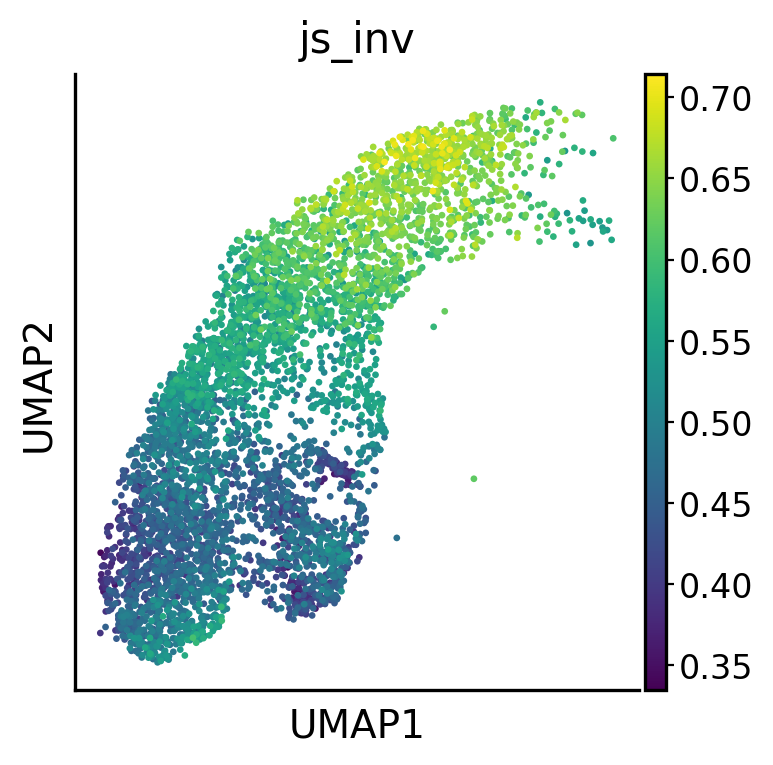

In [35]:
sc.pl.umap(adata_15, color="js_inv")

In [36]:
adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")

/tmp/ipykernel_284558/2605882233.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_15.obs[["cell_type_refined", "js_inv"]].groupby("cell_type_refined").mean().sort_values("js_inv")


,js_inv
cell_type_refined,
Delta,0.424982
Alpha,0.445552
Fev+ Beta,0.450768
Fev+ Alpha,0.455049
Beta,0.467997
Epsilon,0.497921
Fev+,0.504675
"Fev+ Delta,1",0.541977
"Fev+ Delta,0",0.553894
